In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covidct/COVID-CT-MetaInfo.xlsx
/kaggle/input/covidct/CT_NonCOVID/65%4.jpg
/kaggle/input/covidct/CT_NonCOVID/54%1.jpg
/kaggle/input/covidct/CT_NonCOVID/51%1.jpg
/kaggle/input/covidct/CT_NonCOVID/1814.png
/kaggle/input/covidct/CT_NonCOVID/1924.png
/kaggle/input/covidct/CT_NonCOVID/709.png
/kaggle/input/covidct/CT_NonCOVID/889.png
/kaggle/input/covidct/CT_NonCOVID/45.jpg
/kaggle/input/covidct/CT_NonCOVID/20.jpg
/kaggle/input/covidct/CT_NonCOVID/6%0.jpg
/kaggle/input/covidct/CT_NonCOVID/69%1.jpg
/kaggle/input/covidct/CT_NonCOVID/227.png
/kaggle/input/covidct/CT_NonCOVID/39%0.jpg
/kaggle/input/covidct/CT_NonCOVID/36%1.jpg
/kaggle/input/covidct/CT_NonCOVID/579.png
/kaggle/input/covidct/CT_NonCOVID/1048.png
/kaggle/input/covidct/CT_NonCOVID/39%4.jpg
/kaggle/input/covidct/CT_NonCOVID/33%1.jpg
/kaggle/input/covidct/CT_NonCOVID/177.png
/kaggle/input/covidct/CT_NonCOVID/754.png
/kaggle/input/covidct/CT_NonCOVID/104.png
/kaggle/input/covidct/CT_NonCOVID/1312.png
/kaggle/input/covidct

In [2]:
data_root='/kaggle/input/covidct/'
path_positive_cases = os.path.join('/kaggle/input/covidct/CT_COVID/')
path_negative_cases = os.path.join('/kaggle/input/covidct/CT_NonCOVID/')

#Get file paths using glob module
from glob import glob
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))
negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

print(len(positive_images_ls))
print(len(negative_images_ls))

349
397


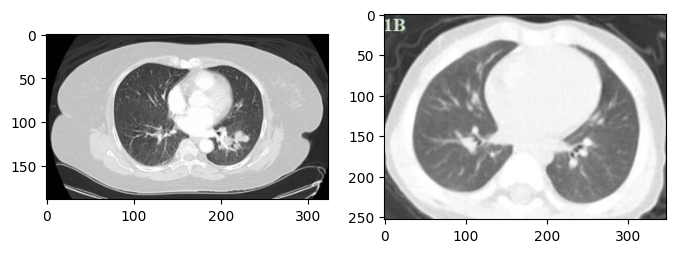

In [3]:
#Print a couple of images just to see 
import cv2 #opencv for reading images
import matplotlib.pyplot as plt
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [4]:
# Create Train-Test Directory

import shutil
import random

subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

random.seed(5)

#Percentage of images to be in test set from original data set is set to 15%
test_ratio = 0.15

#creates seperate folders in train and test for covid and noncovid. This format is required for image generators
for cases in [covid,non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])
    

CT_COVID 52
CT_NonCOVID 59


In [5]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [6]:
total_train_covid = len(os.listdir('/kaggle/working/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/kaggle/working/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/kaggle/working/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 297
Train sets images Non COVID: 338
Test sets images COVID: 52
Test sets images Non COVID: 59


# Preparing 5 folds of the dataset for 5 Fold Cross Validation 

The data has been initially sperated as test and train. The train data is seperated to five equal sections and then 5 folds have been created using the sections.

In [7]:
import os
import shutil
import random

# Define the source directories
covid_source_dir = '/kaggle/working/train/CT_COVID'
noncovid_source_dir = '/kaggle/working/train/CT_NonCOVID'

# Create 5 destination directories
for i in range(1, 6):
    dest_dir = f'/kaggle/working/train/part_{i}'
    os.makedirs(dest_dir, exist_ok=True)
    # Create subdirectories for COVID and non-COVID within each part
    os.makedirs(os.path.join(dest_dir, 'COVID'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'NonCOVID'), exist_ok=True)

# Get the list of files in the source directories
covid_files = os.listdir(covid_source_dir)
noncovid_files = os.listdir(noncovid_source_dir)

# Shuffle the file lists
random.shuffle(covid_files)
random.shuffle(noncovid_files)

# Calculate the number of samples for each part
num_samples = len(covid_files) // 5
num_non = len(noncovid_files)//5

# Split and copy the data into each part directory
for i in range(5):
    start_idx = i * num_samples
    end_idx = (i + 1) * num_samples
    
    start_i = i * num_non
    end_i = (i + 1) * num_non
    
    part_covid = covid_files[start_idx:end_idx]
    part_noncovid = noncovid_files[start_i:end_i]

    for file in part_covid:
        src_path = os.path.join(covid_source_dir, file)
        dest_path = os.path.join(f'/kaggle/working/train/part_{i+1}/COVID', file)
        shutil.copy(src_path, dest_path)

    for file in part_noncovid:
        src_path = os.path.join(noncovid_source_dir, file)
        dest_path = os.path.join(f'/kaggle/working/train/part_{i+1}/NonCOVID', file)
        shutil.copy(src_path, dest_path)


In [8]:
import os

# Define the base directory for your dataset
base_dir = '/kaggle/working/train'

# Create an empty dictionary to store the counts for each part
part_counts = {}

# Iterate over the parts and count the images in the "COVID" and "NonCOVID" subdirectories
for i in range(1, 6):
    part_dir = os.path.join(base_dir, f'part_{i}')
    covid_dir = os.path.join(part_dir, 'COVID')
    noncovid_dir = os.path.join(part_dir, 'NonCOVID')
    
    part_counts[f'Part {i} COVID'] = len(os.listdir(covid_dir))
    part_counts[f'Part {i} NonCOVID'] = len(os.listdir(noncovid_dir))

# Print the counts for each part
for part, count in part_counts.items():
    print(f"{part} images: {count}")


Part 1 COVID images: 59
Part 1 NonCOVID images: 67
Part 2 COVID images: 59
Part 2 NonCOVID images: 67
Part 3 COVID images: 59
Part 3 NonCOVID images: 67
Part 4 COVID images: 59
Part 4 NonCOVID images: 67
Part 5 COVID images: 59
Part 5 NonCOVID images: 67


In [9]:
# Create K_Folds by combining 4 parts for train and 1 part for validation testing
#Note - Already removed a section for the test set


# Define the source directories for the 5 parts
base_dir = '/kaggle/working/train'
parts = [f'part_{i}' for i in range(1, 6)]

# Create 5 destination directories (folds)
for i in range(1, 6):
    dest_dir = f'/kaggle/working/train/fold_{i}'
    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'train', 'COVID'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'train', 'NonCOVID'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'validation', 'COVID'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'validation', 'NonCOVID'), exist_ok=True)

# Define the number of parts for training and validation
parts_for_training = 4
parts_for_validation = 1

# Shuffle the parts to create different folds
random.shuffle(parts)

for i in range(5):
    # Select the parts for training and validation
    validation_part = parts[i]
    training_parts = [part for part in parts if part != validation_part]

    # Create subdirectories for training and validation within each fold
    train_fold_dir = os.path.join(base_dir, f'fold_{i + 1}', 'train')
    validation_fold_dir = os.path.join(base_dir, f'fold_{i + 1}', 'validation')

    train_covid_dir = os.path.join(train_fold_dir, 'COVID')
    train_noncovid_dir = os.path.join(train_fold_dir, 'NonCOVID')
    validation_covid_dir = os.path.join(validation_fold_dir, 'COVID')
    validation_noncovid_dir = os.path.join(validation_fold_dir, 'NonCOVID')

    for part in training_parts:
        # Copy COVID and NonCOVID images from the training parts to the training fold
        for category in ['COVID', 'NonCOVID']:
            source_dir = os.path.join(base_dir, part, category)
            destination_dir = os.path.join(train_fold_dir, category)
            for file in os.listdir(source_dir):
                shutil.copy(os.path.join(source_dir, file), os.path.join(destination_dir, file))

    # Copy COVID and NonCOVID images from the validation part to the validation fold
    for category in ['COVID', 'NonCOVID']:
        source_dir = os.path.join(base_dir, validation_part, category)
        destination_dir = os.path.join(validation_fold_dir, category)
        for file in os.listdir(source_dir):
            shutil.copy(os.path.join(source_dir, file), os.path.join(destination_dir, file))


In [10]:
import os

# Define the base directory for your folds
base_dir = '/kaggle/working/train'

# Create an empty dictionary to store the counts for each fold
fold_counts = {}

for i in range(1, 6):
    fold_dir = os.path.join(base_dir, f'fold_{i}')
    
    # Count COVID and NonCOVID images in the training and validation sets
    train_covid_count = len(os.listdir(os.path.join(fold_dir, 'train', 'COVID')))
    train_noncovid_count = len(os.listdir(os.path.join(fold_dir, 'train', 'NonCOVID')))
    validation_covid_count = len(os.listdir(os.path.join(fold_dir, 'validation', 'COVID')))
    validation_noncovid_count = len(os.listdir(os.path.join(fold_dir, 'validation', 'NonCOVID')))
    
    fold_counts[f'Fold {i}'] = {
        'Train COVID': train_covid_count,
        'Train NonCOVID': train_noncovid_count,
        'Validation COVID': validation_covid_count,
        'Validation NonCOVID': validation_noncovid_count
    }

# Print the counts for each fold
for fold, counts in fold_counts.items():
    print(f"{fold} counts:")
    for category, count in counts.items():
        print(f"{category} images: {count}")


Fold 1 counts:
Train COVID images: 236
Train NonCOVID images: 268
Validation COVID images: 59
Validation NonCOVID images: 67
Fold 2 counts:
Train COVID images: 236
Train NonCOVID images: 268
Validation COVID images: 59
Validation NonCOVID images: 67
Fold 3 counts:
Train COVID images: 236
Train NonCOVID images: 268
Validation COVID images: 59
Validation NonCOVID images: 67
Fold 4 counts:
Train COVID images: 236
Train NonCOVID images: 268
Validation COVID images: 59
Validation NonCOVID images: 67
Fold 5 counts:
Train COVID images: 236
Train NonCOVID images: 268
Validation COVID images: 59
Validation NonCOVID images: 67


**Import TensorFlow**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast,Rescaling
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Add augmented data into each of the 5 folds**

Data augmentation is added to the train sets of each of the 5 folds.
Validation sets and test set are not augmented.

All data sets are scaled.

In [12]:
data_augmentation = tf.keras.Sequential([
    
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

rescale = tf.keras.Sequential([
  Rescaling(1./255)
])

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [34]:
#Prepare Test Set
test_dir = os.path.join('/kaggle/working/test')

total_test_covid = len(os.listdir('/kaggle/working/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/CT_NonCOVID'))
total_test = total_test_covid + total_test_noncovid

unscaled_test_data_gen = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='binary',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
)

test_data_gen = unscaled_test_data_gen.map(
  lambda x, y: (rescale(x, training=True), y),num_parallel_calls=AUTOTUNE)

Found 111 files belonging to 2 classes.


In [15]:
folds = {}
# Iterate over each fold
for i in range(1, 6):
    fold_dir = f'/kaggle/working/train/fold_{i}'

    # Create a data generator for the training data
    preaug_data_gen = tf.keras.utils.image_dataset_from_directory(
        os.path.join(fold_dir, 'train'),
        seed=123,
        label_mode='binary',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size
    )

    # Create a data generator for the validation data within the fold
    unscaled_valid_data_gen = tf.keras.utils.image_dataset_from_directory(
        os.path.join(fold_dir, 'validation'),
        seed=123,
        label_mode='binary',
        image_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    preaug_data_gen = preaug_data_gen.map(
      lambda x, y: (rescale(x, training=True), y),num_parallel_calls=AUTOTUNE)
    
    valid_data_gen = unscaled_valid_data_gen.map(
      lambda x, y: (rescale(x, training=True), y),num_parallel_calls=AUTOTUNE)
    
    train_data_gen_augmented = preaug_data_gen.map(
      lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=AUTOTUNE)
    train_data_gen = preaug_data_gen.concatenate(train_data_gen_augmented)
    
    
    folds[i] = {'train':train_data_gen,'val':valid_data_gen}



Found 504 files belonging to 2 classes.
Found 126 files belonging to 2 classes.
Found 504 files belonging to 2 classes.
Found 126 files belonging to 2 classes.
Found 504 files belonging to 2 classes.
Found 126 files belonging to 2 classes.
Found 504 files belonging to 2 classes.
Found 126 files belonging to 2 classes.
Found 504 files belonging to 2 classes.
Found 126 files belonging to 2 classes.


In [16]:
folds

{1: {'train': <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
  'val': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>},
 2: {'train': <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
  'val': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>},
 3: {'train': <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
  'val': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(

In [25]:
len(folds[1]['train'])

32

# The model architecture is as follows

In [56]:
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 64)     

# Training and Validation - Small Self Trained Model

In [58]:
#Callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
check_point = ModelCheckpoint("./my_model.h5", monitor="val_loss", save_best_only=True)
reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6)
callbacks_list = [early, check_point, reduce]

In [61]:
histories = {}
test_results = {}
# Iterate over each fold
for fold, data_generators in folds.items():
    print("FOLD: ",fold,'\n')
    train_data_gen = data_generators['train']
    valid_data_gen = data_generators['val']

    tr = len(train_data_gen)
    v = len(valid_data_gen)

    # Create and compile your model (if not done already)
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_data_gen,
        steps_per_epoch=tr,
        epochs=50,
        validation_data=valid_data_gen,
        validation_steps=v,
        callbacks=callbacks_list
    )
    
    # Save history in history dict
    histories[fold] = history
    
    
    # Save the model after training
    model.save(f'/kaggle/working/models/model_fold_{fold}.h5')
    
    #Evaluate on test set just to see
    test_results[fold] = model.evaluate(test_data_gen)
    print(test_results[fold])

FOLD:  1 

Epoch 1/50
32/32 [==============================] - 10s 232ms/step - loss: 0.8765 - accuracy: 0.5198 - val_loss: 0.8307 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 7s 208ms/step - loss: 0.7087 - accuracy: 0.5129 - val_loss: 1.1321 - val_accuracy: 0.5317 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 8s 217ms/step - loss: 0.6989 - accuracy: 0.5238 - val_loss: 0.6868 - val_accuracy: 0.5159 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 7s 206ms/step - loss: 0.6748 - accuracy: 0.5288 - val_loss: 0.6777 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 8s 226ms/step - loss: 0.6802 - accuracy: 0.5476 - val_loss: 0.7416 - val_accuracy: 0.5317 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 7s 216ms/step - loss: 0.6842 - accuracy: 0.5913 - val_loss: 1.2395 - val_accuracy: 0.5317 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 7s 210

FOLD:  1 



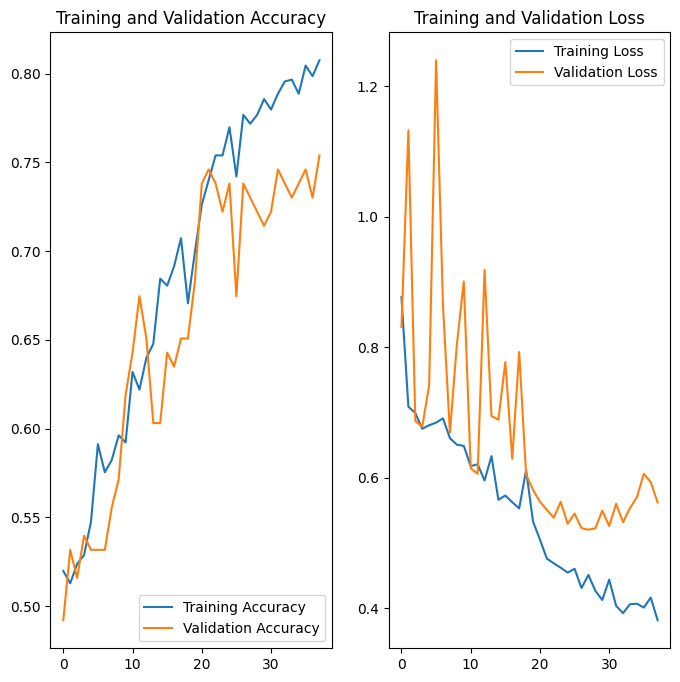

FOLD:  2 



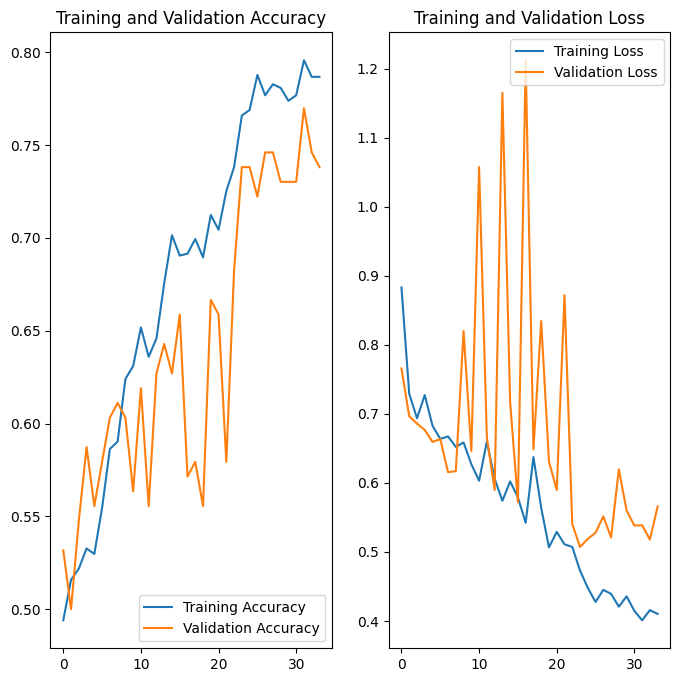

FOLD:  3 



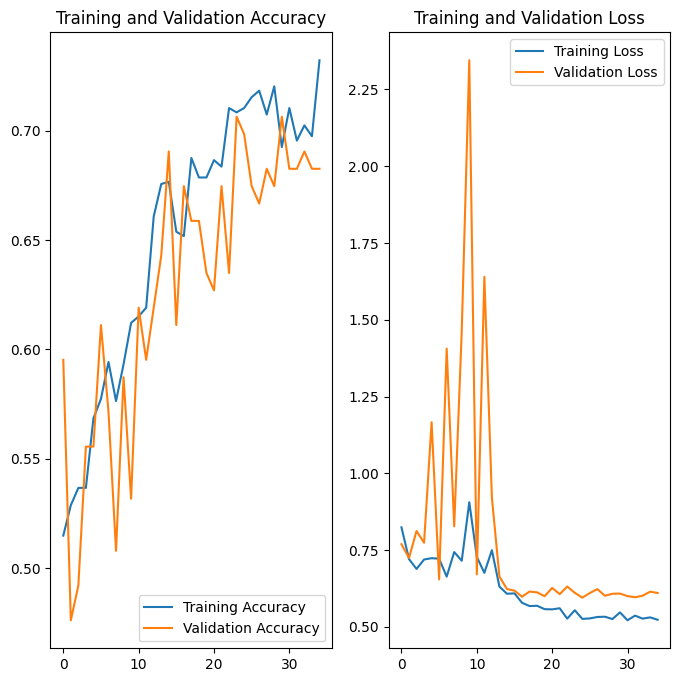

FOLD:  4 



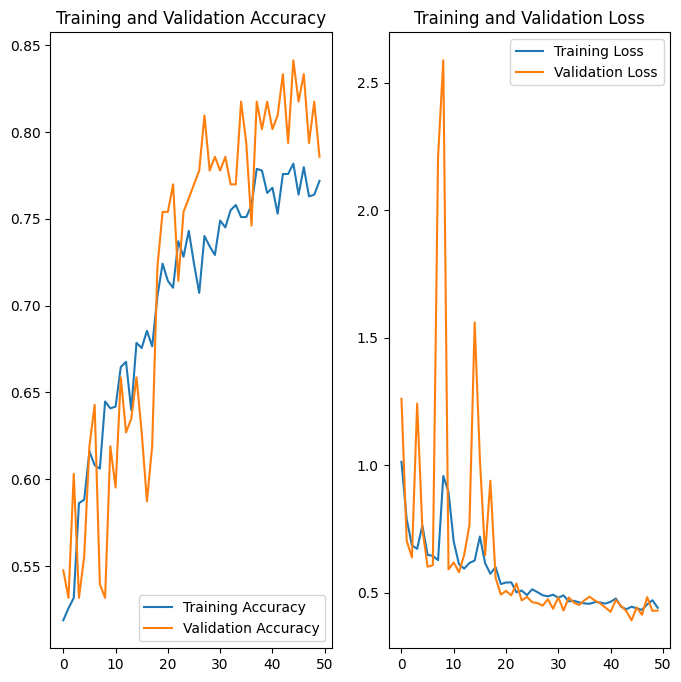

FOLD:  5 



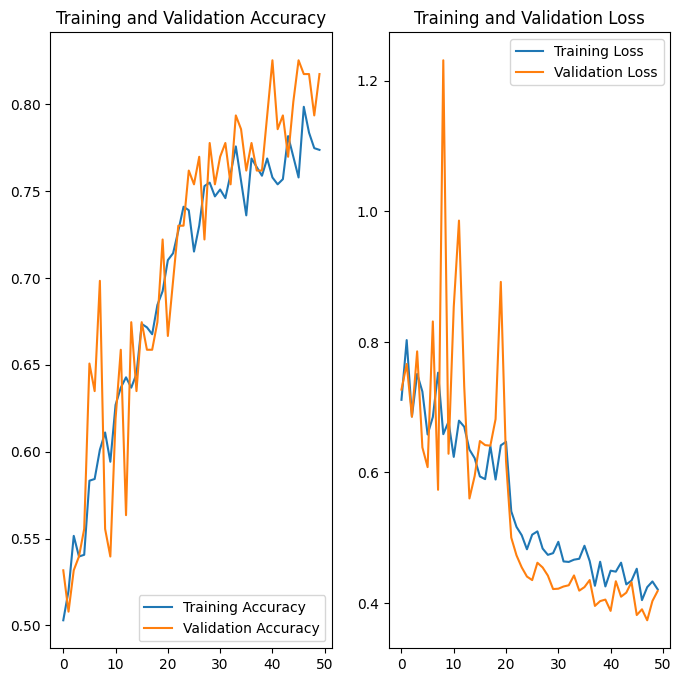

In [62]:
for fold,history in histories.items():
    print("FOLD: ",fold,'\n')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Training and Validation - Transfer Learning Approach

RESNET 50 is used. 

In [42]:
m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/classification/1", trainable=False)
    ])
m.add(tf.keras.layers.Dense(128, activation='relu'))
m.add(tf.keras.layers.Dropout(0.5))
m.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
m.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
          loss='binary_crossentropy',
          metrics=['accuracy'])
m.build((None, 224, 224, 3))
m.summary()    


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1001)              25612201  
                                                                 
 dense_33 (Dense)            (None, 128)               128256    
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 25,740,586
Trainable params: 128,385
Non-trainable params: 25,612,201
_________________________________________________________________


In [29]:
from sklearn.metrics import f1_score, recall_score, precision_score
histories_transfer = {}
test_results_transfer = {}
# Iterate over each fold
for fold, data_generators in folds.items():
    print("FOLD: ",fold,'\n')
    train_data_gen = data_generators['train']
    valid_data_gen = data_generators['val']

    tr = len(train_data_gen)
    v = len(valid_data_gen)

    # Create and compile 
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/classification/1", trainable=False)
    ])
    m.add(tf.keras.layers.Dense(128, activation='relu'))
    m.add(tf.keras.layers.Dropout(0.5))
    m.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
    m.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    m.build((None, 224, 224, 3))

    # Train the model
    history = m.fit(
        train_data_gen,
        steps_per_epoch=tr,
        epochs=50,
        validation_data=valid_data_gen,
        validation_steps=v,
        callbacks=callbacks_list
    )
    
    # Save history in history dict
    histories_transfer[fold] = history
    
    
    # Save the model after training
    m.save(f'/kaggle/working/models/transfer_model_fold_{fold}.h5')
    
    #Evaluate on test set just to see
    test_results_transfer[fold] = m.evaluate(test_data_gen)
    print(test_results[fold],'\n')

FOLD:  1 

Epoch 1/50
32/32 [==============================] - 16s 297ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6919 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 8s 232ms/step - loss: 0.6922 - accuracy: 0.5645 - val_loss: 0.6912 - val_accuracy: 0.6270 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 8s 229ms/step - loss: 0.6917 - accuracy: 0.5575 - val_loss: 0.6905 - val_accuracy: 0.5873 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 8s 225ms/step - loss: 0.6904 - accuracy: 0.5923 - val_loss: 0.6898 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 8s 223ms/step - loss: 0.6906 - accuracy: 0.5605 - val_loss: 0.6891 - val_accuracy: 0.5794 - lr: 1.0000e-04
Epoch 6/50
32/32 [==============================] - 8s 224ms/step - loss: 0.6890 - accuracy: 0.5913 - val_loss: 0.6884 - val_accuracy: 0.5794 - lr: 1.0000e-04
Epoch 7/50
32/32 [================

FOLD:  1 



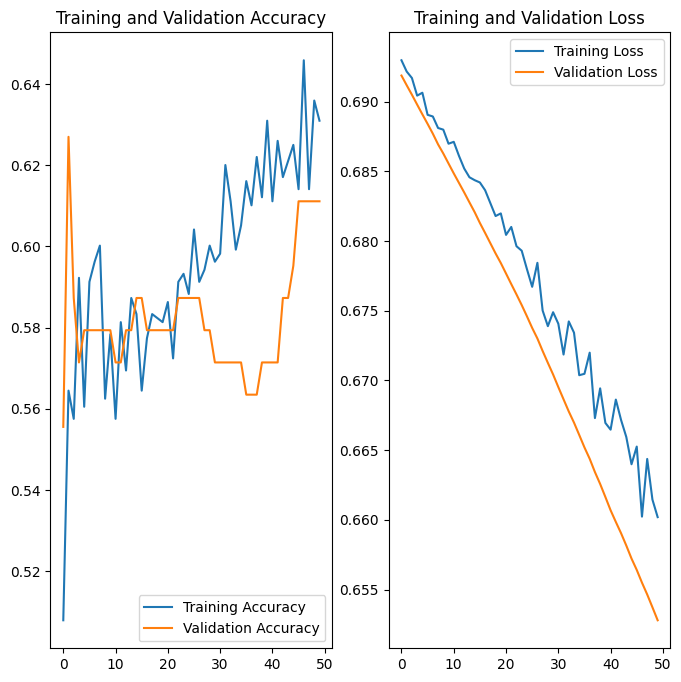

FOLD:  2 



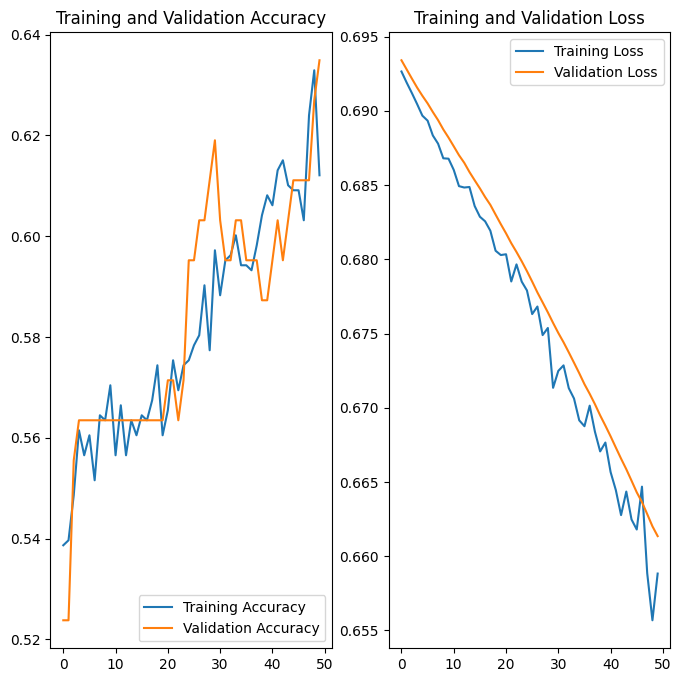

FOLD:  3 



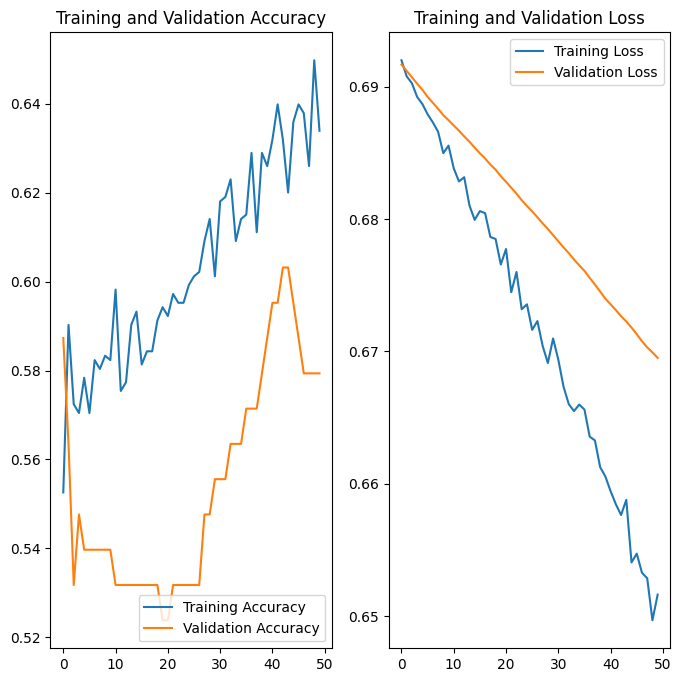

FOLD:  4 



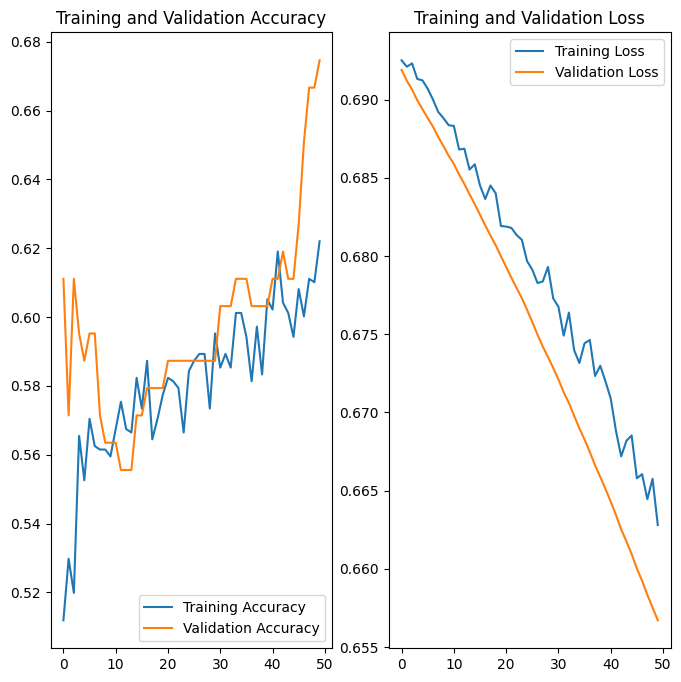

FOLD:  5 



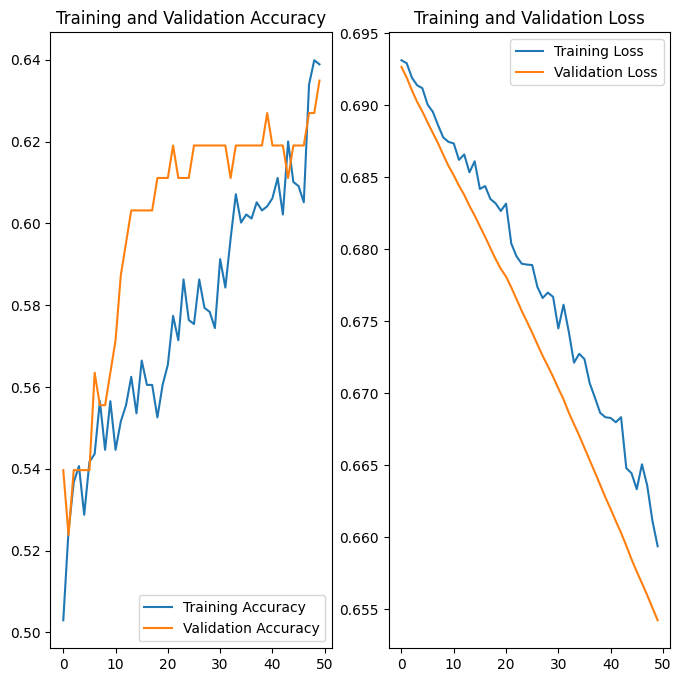

In [30]:
for fold,history in histories_transfer.items():
    print("FOLD: ",fold,'\n')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# **Analysis of Small Model after 50 epochs**

In [64]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Create dictionaries to store accuracy, loss, F1 score, recall, and precision
accuracy_scores = {}
loss_values = {}
f1_scores = {}
recall_scores = {}
# precision_scores = {}

# Iterate over each fold and evaluate accuracy, loss, F1 score, recall, and precision
for fold in folds.keys():
    model_path = f'/kaggle/working/models/model_fold_{fold}.h5'
    print(model_path)
    # Load the model
    loaded_model = tf.keras.models.load_model(model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(test_data_gen)
    test_predictions = loaded_model.predict(test_data_gen)
    true_labels = np.concatenate([y for x, y in test_data_gen])

    # Convert predicted probabilities to binary labels
    predicted_labels = (test_predictions > 0.5).astype(int)

    # Calculate the F1 score, recall, and precision
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
#     precision = precision_score(true_labels, predicted_labels, average='weighted')

    accuracy_scores[fold] = test_accuracy
    loss_values[fold] = test_loss
    f1_scores[fold] = f1
    recall_scores[fold] = recall
#     precision_scores[fold] = precision
print()
# Print accuracy, loss, F1 score, recall, and precision for each fold
for fold in folds.keys():
    print("Metrics for Fold", fold)
    print("Accuracy:", accuracy_scores[fold])
    print("Loss:", loss_values[fold])
    print("F1 Score:", f1_scores[fold])
    print("Recall:", recall_scores[fold])
#     print("Precision:", precision_scores[fold])
    print()


/kaggle/working/models/model_fold_1.h5
4/4 [==============================] - 0s 11ms/step
/kaggle/working/models/model_fold_2.h5
4/4 [==============================] - 0s 10ms/step
/kaggle/working/models/model_fold_3.h5
4/4 [==============================] - 0s 11ms/step
/kaggle/working/models/model_fold_4.h5
4/4 [==============================] - 0s 11ms/step
/kaggle/working/models/model_fold_5.h5
4/4 [==============================] - 0s 11ms/step

Metrics for Fold 1
Accuracy: 0.792792797088623
Loss: 10.970589637756348
F1 Score: 0.5225225225225225
Recall: 0.5225225225225225

Metrics for Fold 2
Accuracy: 0.7117117047309875
Loss: 7.822277069091797
F1 Score: 0.4774774774774775
Recall: 0.4774774774774775

Metrics for Fold 3
Accuracy: 0.6486486196517944
Loss: 5.434665203094482
F1 Score: 0.5677781677781677
Recall: 0.5675675675675675

Metrics for Fold 4
Accuracy: 0.8108108043670654
Loss: 18.56987762451172
F1 Score: 0.5405405405405405
Recall: 0.5405405405405406

Metrics for Fold 5
Accuracy:

# **Analysis of Transfer Learning Method after 50 epochs**

In [48]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Create dictionaries to store accuracy, loss, F1 score, recall, and precision
accuracy_scores = {}
loss_values = {}
f1_scores = {}
recall_scores = {}
precision_scores = {}

# Iterate over each fold and evaluate accuracy, loss, F1 score, recall, and precision
for fold in folds.keys():
    model_path = f'/kaggle/working/models/transfer_model_fold_{fold}.h5'

    # Load the model
    loaded_model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(test_data_gen)
    test_predictions = loaded_model.predict(test_data_gen)
    true_labels = np.concatenate([y for x, y in test_data_gen])

    # Convert predicted probabilities to binary labels
    predicted_labels = (test_predictions > 0.5).astype(int)

    # Calculate the F1 score, recall, and precision for binary classification
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)

    accuracy_scores[fold] = test_accuracy
    loss_values[fold] = test_loss
    f1_scores[fold] = f1
    recall_scores[fold] = recall
    precision_scores[fold] = precision
print()
# Print accuracy, loss, F1 score, recall, and precision for each fold
for fold in folds.keys():
    print("Metrics for Fold", fold)
    print("Accuracy:", accuracy_scores[fold])
    print("Loss:", loss_values[fold])
    print("F1 Score:", f1_scores[fold])
    print("Recall:", recall_scores[fold])
    print("Precision:", precision_scores[fold])
    print()

4/4 [==============================] - 1s 54ms/step

Metrics for Fold 1
Accuracy: 0.6576576828956604
Loss: 0.6560700535774231
F1 Score: 0.625
Recall: 0.7627118644067796
Precision: 0.5294117647058824

Metrics for Fold 2
Accuracy: 0.6126126050949097
Loss: 0.6555994153022766
F1 Score: 0.5906040268456376
Recall: 0.7457627118644068
Precision: 0.4888888888888889

Metrics for Fold 3
Accuracy: 0.6486486196517944
Loss: 0.6507161259651184
F1 Score: 0.6122448979591836
Recall: 0.7627118644067796
Precision: 0.5113636363636364

Metrics for Fold 4
Accuracy: 0.6396396160125732
Loss: 0.6577655076980591
F1 Score: 0.6081081081081081
Recall: 0.7627118644067796
Precision: 0.5056179775280899

Metrics for Fold 5
Accuracy: 0.6396396160125732
Loss: 0.6561551690101624
F1 Score: 0.6027397260273973
Recall: 0.7457627118644068
Precision: 0.5057471264367817



In [53]:
[y for x, y in test_data_gen]


[<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
 array([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)>,
 <tf.Tensor: shape=(32, 1), dtype=float32, numpy=
 array([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],


In [54]:
predicted_labels


array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
    

In [55]:
test_predictions

array([[ 4.1161032e+00],
       [-3.6512067e+00],
       [ 3.0496743e+00],
       [ 2.5160151e+00],
       [-3.2485800e+00],
       [-2.8742800e+00],
       [-9.4668406e-01],
       [ 2.9034839e+00],
       [-1.7361555e-01],
       [-8.7221128e-01],
       [-3.1702127e+00],
       [-1.3955519e+00],
       [ 9.9131947e+00],
       [ 1.8863910e+00],
       [ 4.7728262e+00],
       [-1.8723145e+00],
       [-3.2828245e+00],
       [ 2.0864819e+01],
       [ 3.6506648e+00],
       [ 1.0995398e+00],
       [ 4.0177307e+00],
       [ 5.5222607e-01],
       [-8.7334371e-01],
       [ 3.8778770e+00],
       [-8.0583505e-03],
       [ 1.3159772e+00],
       [-5.1462936e-01],
       [ 9.5838898e-01],
       [ 6.4763360e+00],
       [ 4.0664501e+00],
       [-3.6157153e+00],
       [ 1.9889804e+00],
       [-5.1246786e+00],
       [-3.9469616e+00],
       [-3.3407402e+00],
       [-3.8233669e+00],
       [-7.8021818e-01],
       [ 1.5470359e+01],
       [-6.3070388e+00],
       [ 2.2388699e+01],
